In [1]:
%matplotlib inline
import sigpy as sp
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
plt.style.use('dark_background')
plt.rcParams["savefig.bbox"] = 'tight'

In [2]:
case = "../data/testing/case000"
magn_thresh = 0.00005
maxt1 = 3000
maxt2 = 250

In [3]:
GT = np.load("%s/ref_6min.npy" % case, mmap_mode="r")
GT = sp.fft(GT,axes=(3,))
GT = GT/np.linalg.norm(GT[..., 0].ravel(), ord=np.inf)

In [4]:
ref = np.load("%s/ref_2min.npy" % case, mmap_mode="r")
ref = sp.fft(ref,axes=(3,))
ref = ref/np.linalg.norm(ref[..., 0].ravel(), ord=np.inf)

In [5]:
inp = np.load("%s/init_adj_2min.npy" % case, mmap_mode="r")
inp = sp.fft(inp,axes=(3,))
inp = inp/np.linalg.norm(inp[..., 0].ravel(), ord=np.inf)#

In [6]:
deli = np.load("%s/deli_2min.npy" % case, mmap_mode="r")
deli = sp.fft(deli,axes=(3,))
deli = deli/np.linalg.norm(deli[..., 0].ravel(), ord=np.inf)

In [7]:
fin = np.load("%s/refine_2min_iters_20.npy" % case, mmap_mode="r")
fin = sp.fft(fin,axes=(3,))
fin = fin/np.linalg.norm(fin[..., 0].ravel(), ord=np.inf)

In [8]:
# set up basis and dictionary for quantitative fitting
phi = loadmat("../data/shared/phi.mat")["phi"][:, :5]
phi = phi @ sp.fft(np.eye(phi.shape[-1]), axes=(0,))
mat = loadmat("../data/shared/dictionary.mat")

T1 = mat["T1"].ravel()
T2 = mat["T2"].ravel()
mat = mat["I_b"]
(T2, T1) = np.meshgrid(T2, T1)
T1 = T1.ravel()
T2 = T2.ravel()
mat = phi.conj().T @ np.reshape(mat, (-1, mat.shape[-1])).T
nrm = np.linalg.norm(mat, axis=0)
mat = np.array(mat/nrm[None, :],dtype=np.complex64)

In [9]:
def fit(x, dev, mat):
    dev = sp.Device(dev)
    xp = dev.xp
    with dev:
        mat = sp.to_device(mat, dev)
        x = sp.to_device(x, dev)
        
        cor     = xp.abs(mat.conj().T @ xp.reshape(x, (5, 256 * 256)))
        lst_idx = sp.to_device(xp.argmax(cor, axis=0), -1)
        
        fit_T1  = np.reshape(np.array([T1[idx] for idx in lst_idx], dtype=np.float32), (256, 256))
        fit_T2  = np.reshape(np.array([T2[idx] for idx in lst_idx], dtype=np.float32), (256, 256))
    return (sp.to_device(fit_T1,-1), sp.to_device(fit_T2,-1))

In [10]:
# helper function for vizualization
def coil_shading(x, deg=2, num_points=2048, mskthresh=0.15, lvlthresh=1E-1, printpoly=False, returnmask=False, seed=0):
  np.random.seed(seed)
  deg = deg + 1
  x = np.abs(np.squeeze(x))
  x = x/np.max(x)
  msk = x > mskthresh
  idx = np.argwhere(msk.flatten() > 0)
  idx = idx[np.random.permutation(idx.size)]
  vec = np.zeros((num_points,))
  mat = []
  
  for k in range(num_points):
    ydx = int(idx[k] %  x.shape[1])
    xdx = int(idx[k] // x.shape[1])
    vec[k] = x[xdx, ydx]
    
    row = []
    for xord in range(deg):
      for yord in range(deg):
        row.append(xdx**xord * ydx**yord)
    mat.append(row)
    
  mat = np.array(mat)
  c = np.linalg.pinv(mat).dot(vec)
  
  if (printpoly):
    string = "Polynomial: "
    k = 0
    for xord in range(deg):
      for yord in range(deg):
        string = string + "(%e)x^%dy^%d + " % (c[k], xord, yord)
        k = k + 1
    string = string[:-3]
    print(string)  
  
  res = x * 0
  for xdx in range(x.shape[0]):
    for ydx in range(x.shape[1]):
      k = 0
      for xord in range(deg):
        for yord in range(deg):
          res[xdx, ydx] = res[xdx, ydx] + c[k] * xdx**xord * ydx**yord
          k = k + 1
  res[res < lvlthresh] = lvlthresh
  if returnmask:
    return (res, msk)
  return res

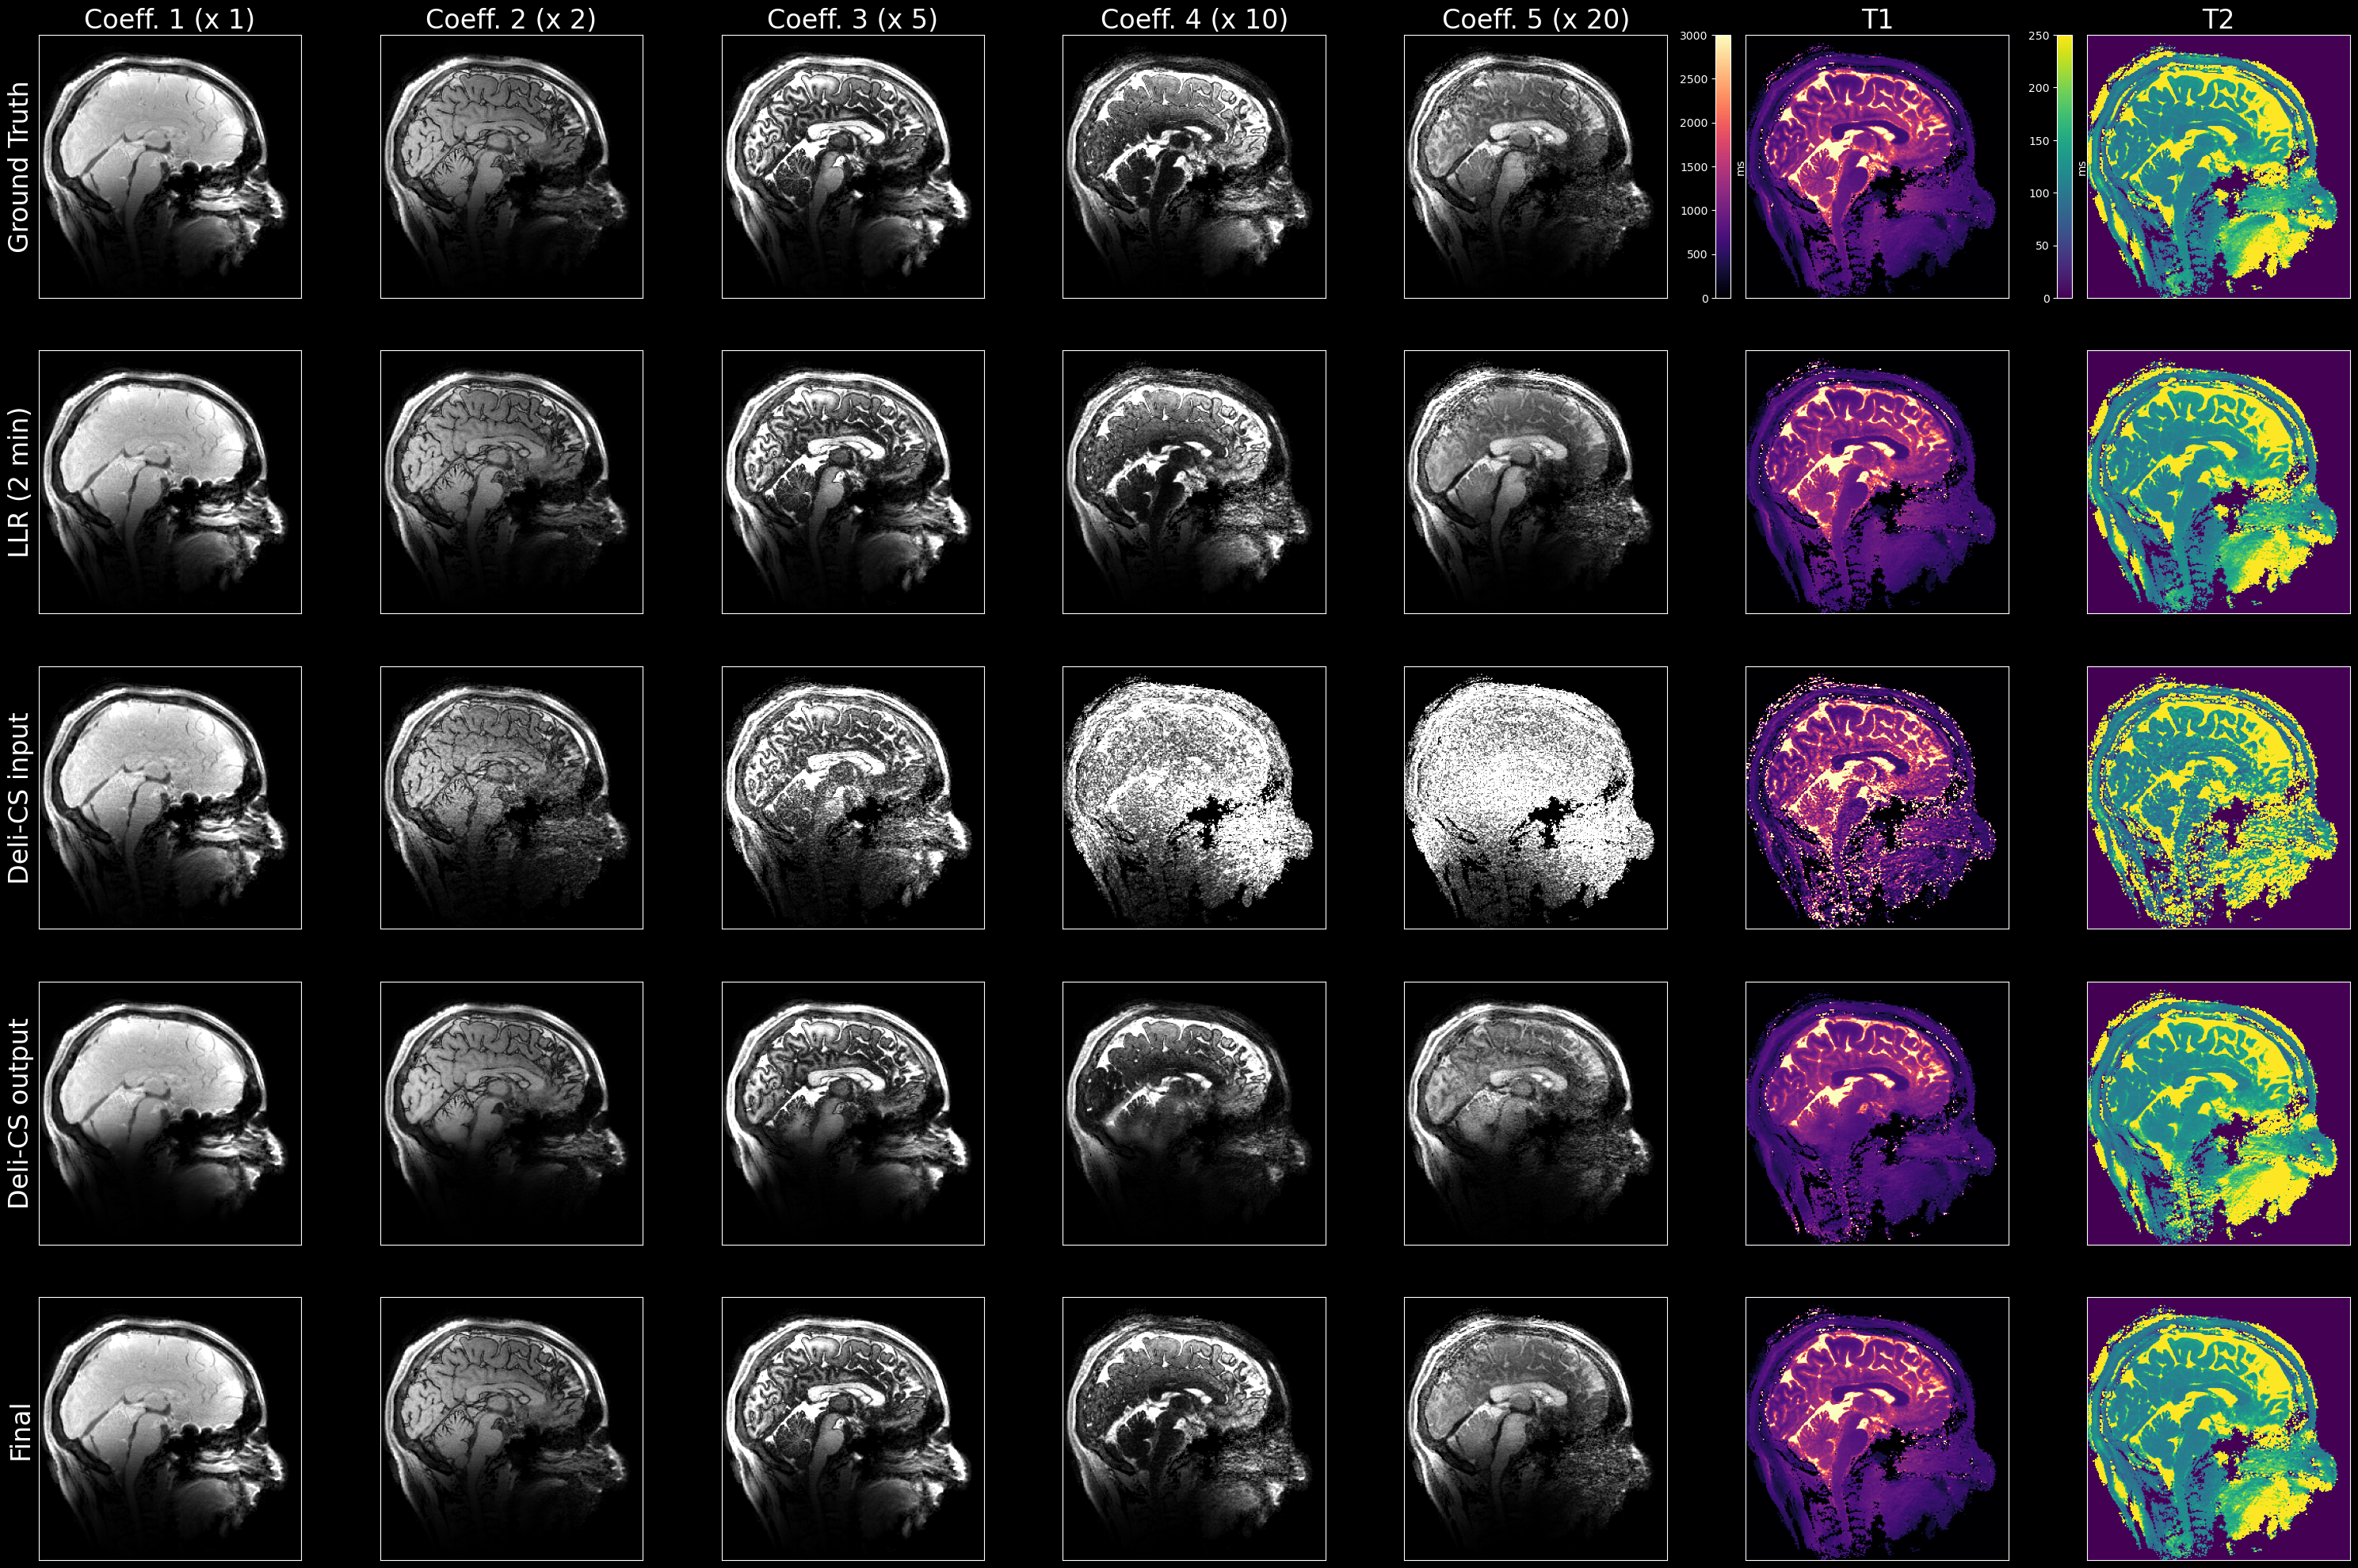

In [11]:
scale = [1/1,1/2,1/5,1/10,1/20]
fig, axs = plt.subplots(5, 7, figsize=(38, 25))

idx = [128, slice(None), slice(None, None, -1)]

dev = 0
p_r1 = fit(sp.ifft(np.array(GT[tuple(idx+[slice(None)])],dtype=np.complex64),axes=[-1,]).T,  dev, np.array(np.imag(mat),dtype=np.float32))
p_r2 = fit(sp.ifft(np.array(ref[tuple(idx+[slice(None)])],dtype=np.complex64),axes=[-1,]).T,  dev, np.array(np.imag(mat),dtype=np.float32))
p_d1 = fit(sp.ifft(np.array(inp[tuple(idx+[slice(None)])],dtype=np.complex64),axes=[-1,]).T,  dev, np.array(np.imag(mat),dtype=np.float32))
p_d2 = fit(sp.ifft(np.array(deli[tuple(idx+[slice(None)])],dtype=np.complex64),axes=[-1,]).T,  dev, np.array(np.imag(mat),dtype=np.float32))
p_d3 = fit(sp.ifft(np.array(fin[tuple(idx+[slice(None)])],dtype=np.complex64),axes=[-1,]).T,  dev, np.array(np.imag(mat),dtype=np.float32))

msk = ((np.abs(GT[..., 0])/np.linalg.norm(GT[..., 0])) > magn_thresh)[tuple(idx)]
cs = coil_shading(GT[tuple(idx + [0])], deg=3)


for k in range(5):
    axs[0][k].imshow((msk * np.abs(GT[tuple(idx + [k])])/cs).T * int(scale[0]/scale[k]), cmap="gray", vmin=0, vmax=1)
    axs[1][k].imshow((msk * np.abs(ref[tuple(idx + [k])])/cs).T * int(scale[0]/scale[k]), cmap="gray", vmin=0, vmax=1)
    axs[2][k].imshow((msk * np.abs(inp[tuple(idx + [k])])/cs).T * int(scale[0]/scale[k]), cmap="gray", vmin=0, vmax=1)
    axs[3][k].imshow((msk * np.abs(deli[tuple(idx + [k])])/cs).T * int(scale[0]/scale[k]), cmap="gray", vmin=0, vmax=1)
    axs[4][k].imshow((msk * np.abs(fin[tuple(idx + [k])])/cs).T * int(scale[0]/scale[k]), cmap="gray", vmin=0, vmax=1)
    axs[0][k].set_title("Coeff. %d (x %d)" % (k + 1, int(scale[0]/scale[k])), fontsize=24)

im1 = axs[0][5].imshow((msk.T * (p_r1[0])) , cmap="magma", vmin=0, vmax=maxt1)
im2 = axs[0][6].imshow((msk.T * (p_r1[1])) , cmap="viridis", vmin=0, vmax=maxt2)
axs[1][5].imshow((msk.T * (p_r2[0])) , cmap="magma", vmin=0, vmax=maxt1)
axs[1][6].imshow((msk.T * (p_r2[1])) , cmap="viridis", vmin=0, vmax=maxt2)
axs[2][5].imshow((msk.T * (p_d1[0])) , cmap="magma", vmin=0, vmax=maxt1)
axs[2][6].imshow((msk.T * (p_d1[1])) , cmap="viridis", vmin=0, vmax=maxt2)
axs[3][5].imshow((msk.T * (p_d2[0])) , cmap="magma", vmin=0, vmax=maxt1)
axs[3][6].imshow((msk.T * (p_d2[1])) , cmap="viridis", vmin=0, vmax=maxt2)
axs[4][5].imshow((msk.T * (p_d3[0])) , cmap="magma", vmin=0, vmax=maxt1)
axs[4][6].imshow((msk.T * (p_d3[1])) , cmap="viridis", vmin=0, vmax=maxt2)

axs[0][5].set_title("T1" , fontsize=24)
axs[0][6].set_title("T2" , fontsize=24)

axs[0][0].set_ylabel("Ground Truth", fontsize=24)
axs[1][0].set_ylabel("LLR (2 min)", fontsize=24)
axs[2][0].set_ylabel("Deli-CS input", fontsize=24)
axs[3][0].set_ylabel("Deli-CS output", fontsize=24)
axs[4][0].set_ylabel("Final", fontsize=24)


box1 = (axs[0][5]).get_position()
axColor = plt.axes([box1.x0-0.01, box1.y0, 0.005, box1.height])
plt.colorbar(im1, cax=axColor,shrink=1,label='ms')
axColor.yaxis.set_ticks_position('left')

box2 = (axs[0][6]).get_position()
axColor = plt.axes([box2.x0-0.01, box2.y0, 0.005, box2.height])
plt.colorbar(im2, cax=axColor,shrink=1,label='ms')
axColor.yaxis.set_ticks_position('left')


for ax in axs.ravel():
    ax.set_xticks([])
    ax.set_yticks([])

plt.savefig('05_compare_recons.png')